In [1]:
from pandas_datareader import data as pdr
import yfinance as yf
import ta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


In [7]:
def fetch_data(name, start, end, scale=None):
    data = yf.download(name, start=start, end=end)
    
    if scale:
        scaler = MinMaxScaler()
        data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
    
    return data

    

def add_target_column (data,variable, name):
    tmp = data[variable].diff().shift(-1).values
    data.loc[:,name] = [ 1 if tmp[i] > 0 else 0 for i in range(tmp.shape[0])]

    return data

def add_ta_features(data,window_sizes=[10]):

    obv =  ta.volume.on_balance_volume(data['Close'], data['Volume'])
    data.loc[:,'OBV'] = obv

    for i in window_sizes:
    
        rsi =  ta.momentum.RSIIndicator(data['Close'], window = i, fillna = True)
        data.loc[:,'RSI_{}'.format(i)] = rsi.rsi()
        
        roc =  ta.momentum.ROCIndicator(data['Close'], window = i, fillna = True)
        data.loc[:,'ROC_{}'.format(i)] = roc.roc()
        
        sma = ta.trend.SMAIndicator(data['Close'],window = i, fillna = True)
        data.loc[:,'SMA_{}'.format(i)] = sma.sma_indicator()
    
        wma = ta.trend.WMAIndicator(data['Close'],window = i, fillna = True)
        data.loc[:,'WMA_{}'.format(i)] = wma.wma()

        kama = ta.momentum.KAMAIndicator(data['Close'],window = i, fillna = True)
        data.loc[:,'KAMA_{}'.format(i)] = kama.kama()

    return data

def add_ratio_trend_features(data, target,variable, window_sizes = [2,5,10,20,40,60]):
    
    
    for hor in window_sizes:
        
        rolling_averages = data.rolling(hor).mean()
        
        ratio_col = 'ratio_{}'.format(hor)
        data.loc[:,ratio_col] = data[variable]/rolling_averages[variable]
        
        if target in data.columns:
            
            trend_col = 'rTrend_{}'.format(hor)
            data.loc[:,trend_col] = data.shift(1).rolling(hor).sum(
                    )[target]
            
    return data
    

def add_custom_features(data):

    data['volatility'] = (data['High'] - data['Low']) / data['Low'] * 100
    data['hc_change'] = (data['Close'] - data['High']) / data['High'] * 100
    data['lc_change'] = (data['Close'] - data['Low']) / data['Low'] * 100
    data['price_change_percent'] = (data['Close'].pct_change() * 100).round(2)

    return data



# load btc

In [8]:
name     = 'BTC-USD'

start    ='2017-01-01'
end      ='2023-11-30'
target   = 'TargetClass' 
variable = 'Close'

import yfinance as yf
import pandas as pd
import ta
from sklearn.preprocessing import MinMaxScaler

# Fetch and process a single dataset
def process_data(name, start, end, target, variable, window_sizes=[10]):
    data = fetch_data(name, start, end, scale=False)
    data = add_ta_features(data, window_sizes=window_sizes)
    data = add_ratio_trend_features(data, target, variable)
    data = data.dropna().copy(deep=True)
    data = add_custom_features(data)
    data = data.bfill()
    return data

# Bitcoin data
data_btc = process_data('BTC-USD', start, end, target, variable)
data_btc = add_target_column(data_btc,variable, target)  # Added after processing
data_btc = data_btc.rename(columns=lambda x: x + '_btc')

# Gold data
data_gold = process_data('GC=F', start, end, target, variable)
data_gold = data_gold.rename(columns=lambda x: x + '_gold')

# Oil data
data_oil = process_data('CL=F', start, end, target, variable)
data_oil = data_oil.rename(columns=lambda x: x + '_oil')

# Merging datasets
data = pd.merge(data_btc.reset_index(), data_gold.reset_index(), on='Date', how='left')
data = pd.merge(data, data_oil.reset_index(), on='Date', how='left')

# Drop columns or perform further operations as needed
# Example: data = data.dropna()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [9]:
data.to_csv('data/btc_gold_oil.csv')

In [10]:
data.columns

Index(['Date', 'Open_btc', 'High_btc', 'Low_btc', 'Close_btc', 'Adj Close_btc',
       'Volume_btc', 'OBV_btc', 'RSI_10_btc', 'ROC_10_btc', 'SMA_10_btc',
       'WMA_10_btc', 'KAMA_10_btc', 'ratio_2_btc', 'ratio_5_btc',
       'ratio_10_btc', 'ratio_20_btc', 'ratio_40_btc', 'ratio_60_btc',
       'volatility_btc', 'hc_change_btc', 'lc_change_btc',
       'price_change_percent_btc', 'TargetClass_btc', 'Open_gold', 'High_gold',
       'Low_gold', 'Close_gold', 'Adj Close_gold', 'Volume_gold', 'OBV_gold',
       'RSI_10_gold', 'ROC_10_gold', 'SMA_10_gold', 'WMA_10_gold',
       'KAMA_10_gold', 'ratio_2_gold', 'ratio_5_gold', 'ratio_10_gold',
       'ratio_20_gold', 'ratio_40_gold', 'ratio_60_gold', 'volatility_gold',
       'hc_change_gold', 'lc_change_gold', 'price_change_percent_gold',
       'Open_oil', 'High_oil', 'Low_oil', 'Close_oil', 'Adj Close_oil',
       'Volume_oil', 'OBV_oil', 'RSI_10_oil', 'ROC_10_oil', 'SMA_10_oil',
       'WMA_10_oil', 'KAMA_10_oil', 'ratio_2_oil', 'ratio_

In [11]:
nan_values = data.isna()
any_missing_values = nan_values.any().any()

any_missing_values_in_column = nan_values.any()

missing_value_count = data.isnull().sum()

for column, has_missing in any_missing_values_in_column.items():
    if has_missing:
        count = missing_value_count[column]
        print(f"-----> Column '{column}' has {count} missing values.")
        
print("\nMissing Values in the Entire DataFrame?")
print(any_missing_values)

print("\nMissing Values in Each Column?")
print(any_missing_values_in_column)

print("\nMissing Value Counts in Each Column:")
print(missing_value_count)

-----> Column 'Open_gold' has 785 missing values.
-----> Column 'High_gold' has 785 missing values.
-----> Column 'Low_gold' has 785 missing values.
-----> Column 'Close_gold' has 785 missing values.
-----> Column 'Adj Close_gold' has 785 missing values.
-----> Column 'Volume_gold' has 785 missing values.
-----> Column 'OBV_gold' has 785 missing values.
-----> Column 'RSI_10_gold' has 785 missing values.
-----> Column 'ROC_10_gold' has 785 missing values.
-----> Column 'SMA_10_gold' has 785 missing values.
-----> Column 'WMA_10_gold' has 785 missing values.
-----> Column 'KAMA_10_gold' has 785 missing values.
-----> Column 'ratio_2_gold' has 785 missing values.
-----> Column 'ratio_5_gold' has 785 missing values.
-----> Column 'ratio_10_gold' has 785 missing values.
-----> Column 'ratio_20_gold' has 785 missing values.
-----> Column 'ratio_40_gold' has 785 missing values.
-----> Column 'ratio_60_gold' has 785 missing values.
-----> Column 'volatility_gold' has 785 missing values.
-----

In [ ]:
btc_df_2023_october = btc_df[(btc_df['date'].dt.year == 2023) 
                             & (btc_df['date'].dt.month == 9)]

dates = btc_df_2023_october['date']
open_prices = btc_df_2023_october['open']
high_prices = btc_df_2023_october['high']
low_prices = btc_df_2023_october['low']

plt.figure(figsize=(16, 8))
plt.gca().set_facecolor('black')

plt.plot(dates, high_prices, label='High', color='green')
plt.plot(dates, low_prices, label='Low', color='red')

plt.fill_between(dates, low_prices, high_prices,
                 where=(high_prices > low_prices),
                 alpha=0.3, color='white')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BTC Price Range (High-Low) for Sep 2023')
plt.legend()

plt.grid(color='white', alpha=0.2)
plt.show()

In [20]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


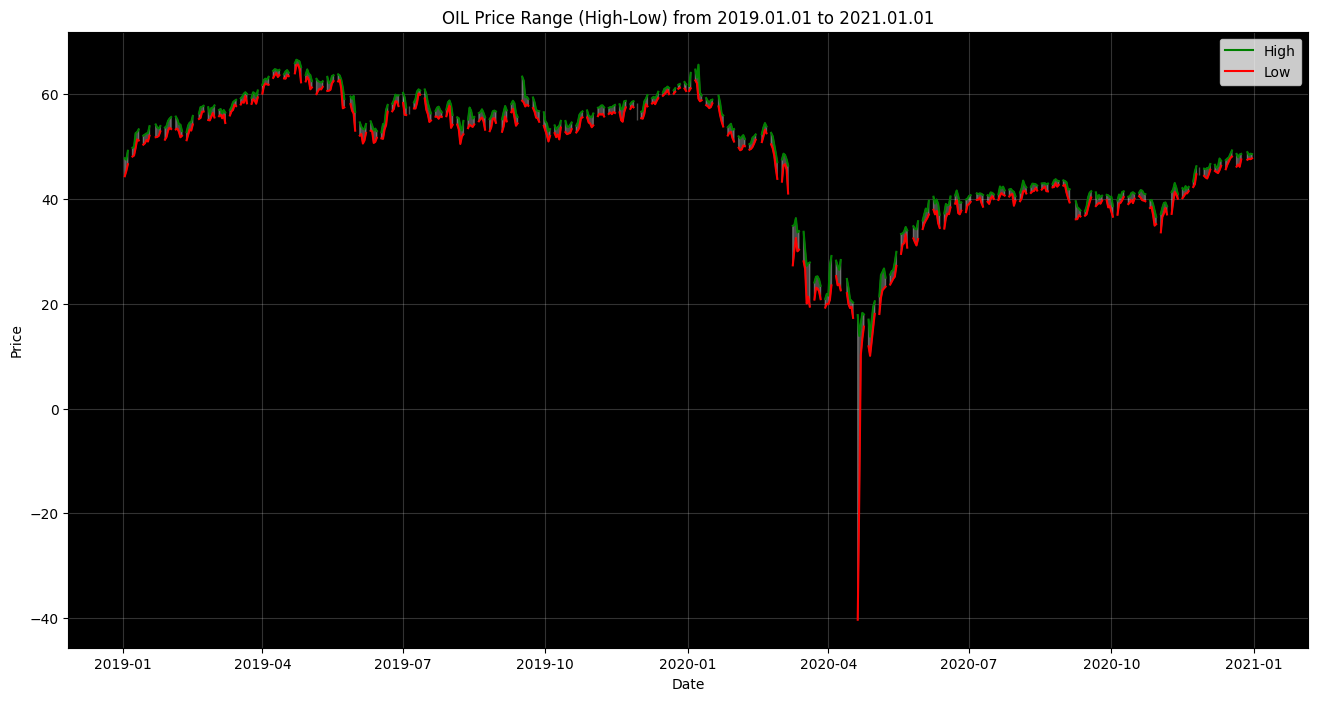

In [68]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_price_range(data, start, end, asset_name):
    """
    Plots the price range (High-Low) for a specified asset within a given date range.
    
    Parameters:
        data (pd.DataFrame): The dataset containing the price data.
        start (str): The start date in 'YYYY.MM.DD' format.
        end (str): The end date in 'YYYY.MM.DD' format.
        asset_name (str): The name of the asset, e.g., 'gold', 'btc'.
    """
    # Convert the start and end strings to datetime objects
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    
    # Filter the data using the extracted dates
    data_tmp = data[(data['Date'] > start_date) & (data['Date'] < end_date)]
    
    # Extract relevant columns for plotting
    dates = data_tmp['Date']
    open_prices = data_tmp['Open_' + asset_name]
    high_prices = data_tmp['High_' + asset_name]
    low_prices = data_tmp['Low_' + asset_name]
    
    # Plotting
    plt.figure(figsize=(16, 8))
    plt.gca().set_facecolor('black')
    
    plt.plot(dates, high_prices, label='High', color='green')
    plt.plot(dates, low_prices, label='Low', color='red')
    
    plt.fill_between(dates, low_prices, high_prices,
                     where=(high_prices > low_prices),
                     alpha=0.3, color='white')
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{asset_name.upper()} Price Range (High-Low) from {start} to {end}')
    plt.legend()
    
    plt.grid(color='white', alpha=0.2)
    plt.show()

# Example usage:
plot_price_range(data, '2019.01.01', '2021.01.01', 'oil')


In [70]:
data.columns

Index(['Date', 'Open_btc', 'High_btc', 'Low_btc', 'Close_btc', 'Adj Close_btc',
       'Volume_btc', 'OBV_btc', 'RSI_10_btc', 'ROC_10_btc', 'SMA_10_btc',
       'WMA_10_btc', 'KAMA_10_btc', 'ratio_2_btc', 'ratio_5_btc',
       'ratio_10_btc', 'ratio_20_btc', 'ratio_40_btc', 'ratio_60_btc',
       'volatility_btc', 'hc_change_btc', 'lc_change_btc',
       'price_change_percent_btc', 'TargetClass_btc', 'Open_gold', 'High_gold',
       'Low_gold', 'Close_gold', 'Adj Close_gold', 'Volume_gold', 'OBV_gold',
       'RSI_10_gold', 'ROC_10_gold', 'SMA_10_gold', 'WMA_10_gold',
       'KAMA_10_gold', 'ratio_2_gold', 'ratio_5_gold', 'ratio_10_gold',
       'ratio_20_gold', 'ratio_40_gold', 'ratio_60_gold', 'volatility_gold',
       'hc_change_gold', 'lc_change_gold', 'price_change_percent_gold',
       'Open_oil', 'High_oil', 'Low_oil', 'Close_oil', 'Adj Close_oil',
       'Volume_oil', 'OBV_oil', 'RSI_10_oil', 'ROC_10_oil', 'SMA_10_oil',
       'WMA_10_oil', 'KAMA_10_oil', 'ratio_2_oil', 'ratio_

In [75]:
asset_name = 'btc'

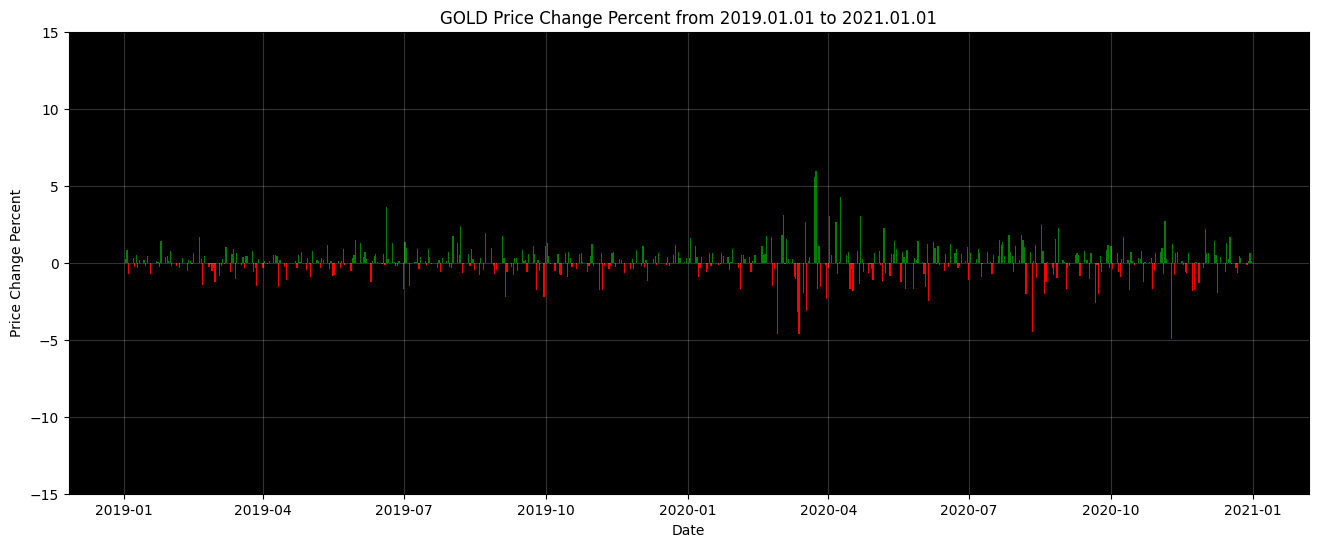

In [80]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_price_change_percent(data, start, end, asset_name):
    """
    Plots the price change percentage for a specified asset within a given date range.
    
    Parameters:
        data (pd.DataFrame): The dataset containing the price data.
        start (str): The start date in 'YYYY.MM.DD' format.
        end (str): The end date in 'YYYY.MM.DD' format.
        asset_name (str): The name of the asset, e.g., 'gold', 'btc'.
    """
    # Convert the start and end strings to datetime objects
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    
    # Filter the data using the extracted dates
    data_tmp = data[(data['Date'] > start_date) & (data['Date'] < end_date)]
    
    # Extract the relevant column for plotting
    price_change_percent = data_tmp['price_change_percent_' + asset_name]
    
    # Plotting
    plt.figure(figsize=(16, 6))
    plt.gca().set_facecolor('black')
    
    # Color the bars green for positive and red for negative price changes
    bars = plt.bar(data_tmp['Date'], price_change_percent, 
                   color=['g' if p >= 0 else 'r' for p in price_change_percent])
    
    # Set y-axis limits
    plt.ylim(-15, 15)
    
    plt.xlabel('Date')
    plt.ylabel('Price Change Percent')
    plt.title(f'{asset_name.upper()} Price Change Percent from {start} to {end}')
    
    plt.grid(color='white', alpha=0.2)
    
    plt.show()

# Example usage:
%matplotlib inline
plot_price_change_percent(data, '2019.01.01', '2021.01.01', 'gold')


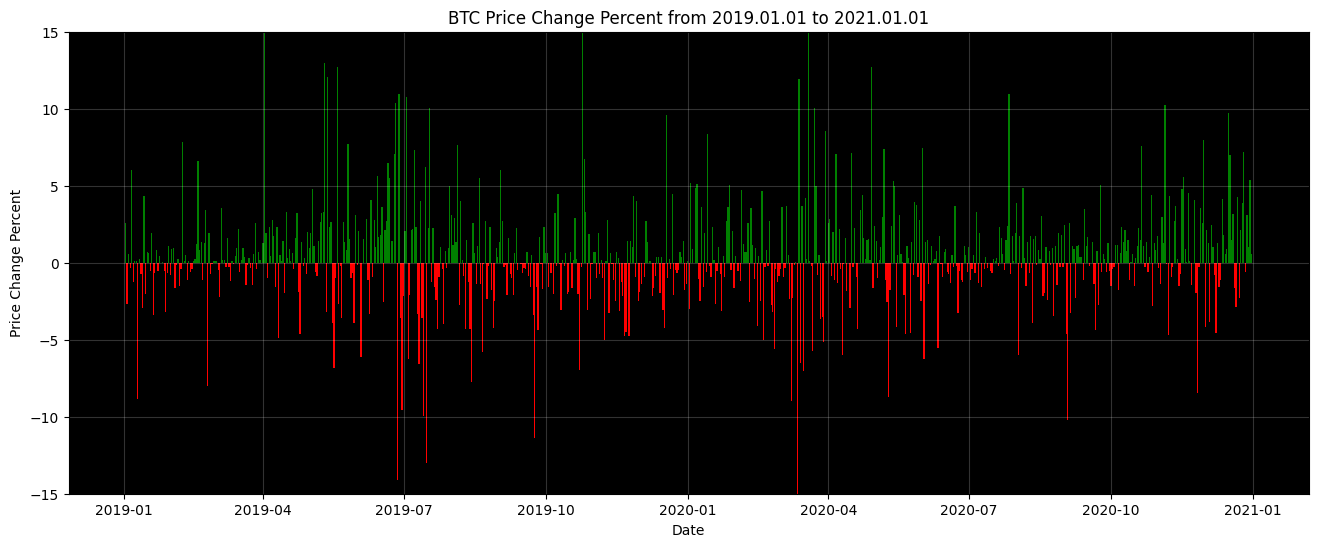

In [81]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_price_change_percent(data, start, end, asset_name):
    """
    Plots the price change percentage for a specified asset within a given date range.
    
    Parameters:
        data (pd.DataFrame): The dataset containing the price data.
        start (str): The start date in 'YYYY.MM.DD' format.
        end (str): The end date in 'YYYY.MM.DD' format.
        asset_name (str): The name of the asset, e.g., 'gold', 'btc'.
    """
    # Convert the start and end strings to datetime objects
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    
    # Filter the data using the extracted dates
    data_tmp = data[(data['Date'] > start_date) & (data['Date'] < end_date)]
    
    # Extract the relevant column for plotting
    price_change_percent = data_tmp['price_change_percent_' + asset_name]
    
    # Plotting
    plt.figure(figsize=(16, 6))
    plt.gca().set_facecolor('black')
    
    # Color the bars green for positive and red for negative price changes
    bars = plt.bar(data_tmp['Date'], price_change_percent, 
                   color=['g' if p >= 0 else 'r' for p in price_change_percent])
    
    # Set y-axis limits
    plt.ylim(-15, 15)
    
    plt.xlabel('Date')
    plt.ylabel('Price Change Percent')
    plt.title(f'{asset_name.upper()} Price Change Percent from {start} to {end}')
    
    plt.grid(color='white', alpha=0.2)
    
    plt.show()

# Example usage:
%matplotlib inline
plot_price_change_percent(data, '2019.01.01', '2021.01.01', 'btc')

In [83]:
import seaborn as sns

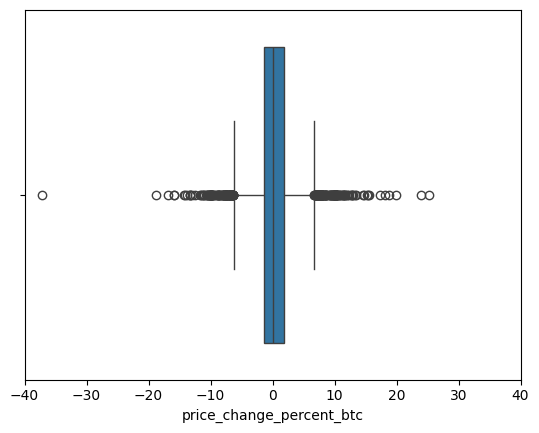

In [92]:
sns.boxplot(data=data,x='price_change_percent_btc')
plt.xlim(-40,40)
plt.show()

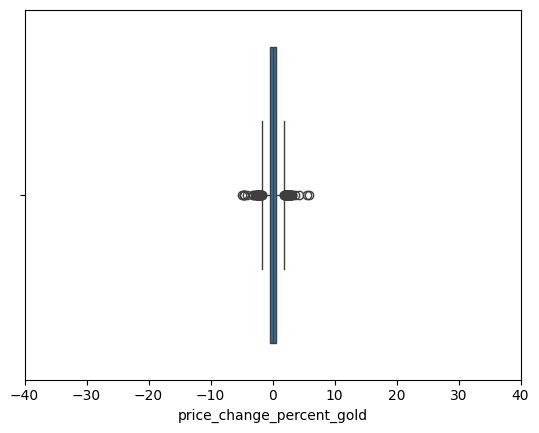

In [91]:
sns.boxplot(data=data,x='price_change_percent_gold')
plt.xlim(-40,40)
plt.show()

In [94]:
pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 37.3 MB/s eta 0:00:00MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [95]:
from statsmodels.tsa.seasonal import STL

In [110]:
#data['Date'] = pd.to_datetime(data['Date'])
#data.set_index('Date', inplace=True)

# Assuming your data has a clear weekly seasonality and is daily data:
period = 7  # Weekly seasonality for daily data

# Initialize STL decomposition with the specified period
stl = STL(data['price_change_percent_' + asset_name].dropna(), seasonal=period)

# Fit the model
res = stl.fit()

# Plot the results
fig = res.plot()
plt.show()


ValueError: Unable to determine period from endog

In [107]:
asset_name = 'gold'

# Initialize STL decomposition with the specified period
stl = STL(data['price_change_percent_' + asset_name].dropna(), seasonal=period)

# Fit the model
res = stl.fit()

# Plot the results
fig = res.plot()
plt.show()


ValueError: Unable to determine period from endog

In [111]:
data.isna().sum()

Open_btc                      0
High_btc                      0
Low_btc                       0
Close_btc                     0
Adj Close_btc                 0
                           ... 
ratio_60_oil                784
volatility_oil              784
hc_change_oil               784
lc_change_oil               784
price_change_percent_oil    784
Length: 67, dtype: int64

In [114]:
data['price_change_percent_' + asset_name]

Date
2017-03-01     NaN
2017-03-02     NaN
2017-03-03     NaN
2017-03-04     NaN
2017-03-05     NaN
              ... 
2023-11-25     NaN
2023-11-26     NaN
2023-11-27    0.48
2023-11-28    1.39
2023-11-29    0.36
Name: price_change_percent_gold, Length: 2465, dtype: float64